# Quantum Approximate Optimization Algorithm

>The **Quantum Approximate Optimization Algorithm (QAOA)**, introduced by Edward Farhi, Jeffrey Goldstone, and Sam Gutmannan [[1](#QAOA)], is a hybrid quantum–classical method for tackling combinatorial optimization problems like Max-Cut, scheduling, and constraint satisfaction. It prepares a parameterized quantum state by alternating two simple operations: one that encodes the problem’s cost function and another that “mixes” amplitudes across candidate solutions. After measuring the circuit, a classical optimizer updates the parameters to increase the expected cost, repeating this loop until good solutions are found. QAOA is especially appealing for near-term quantum devices because it uses shallow circuits, yet its quality can systematically improve as you increase the number of alternating layers. We demonstrate the algorithm by analyzing the Max-Cut and Knapsack problems. The former is an unconstrained optimization problem, while the latter is a constrained task. 
>
> - **Input:** Classical objective function $C(x)=\sum_{\alpha=1}^{m} C_{\alpha}(x)$ returning the number of satisied clauses by the $n$ bit string $x$, where  $C_{\alpha}(x)$ evaluates to $1$ if $z$ satisfies clause $\alpha$ and $0$ otherwise.  
> - **Output:** Binary string $x^*$, constituting the best solution from the pool of solution candidates, maximizing the objective function.
>
> **Complexity:** The algorithm involves iteration over two types of operations. The "cost" operations involve $O(m)$ two-qubit gates, scaling linearly with the number of clauses m. While the mixing operation involves $n$ single-qubit gates. Hence, a single shot of a $p$-depth QAOA circuit includes $O(p(n+m))$ single and double qubit gates. 
>
> ---
>
> **Keywords:** Hybrid Algorithm, Variational Quantum Algorithm, Adiabatic Theorem, Combinatorial Optimization.

## Algorithm Description

The QAOA algorithm prepares a variational quantum state by an iterative procedure: $$|\boldsymbol{\gamma}\boldsymbol{\beta}\rangle = \left( U_M(\gamma_p)U_C(\beta_p)\dots U_M( \gamma_1)U_C(\beta_1)\right)|+\rangle^{\otimes n}~~.$$ Each iteration is comprises of two key operational "layers":

1. **Cost layer:**  
   A phase rotation in the $Z$-direction is applied based on the cost function:
   $$
   |x\rangle \xrightarrow{U_{\text{C}}(\gamma)} e^{i\gamma H_C(x)} |x\rangle ,
   $$
   where $H_C(x)$ is diagonal in the computational basis, encoding the classical cost function $C(x)$. 

3. **Mixer layer:**  
   An $X$-rotation is applied to all qubits:
   $$
   U_B(\beta) = e^{-i\beta H_M}, \quad \text{with } H_M = \sum_i X_i.
   $$
   This operation induces transitions between computational basis states based on the phases that were assigned by the previous layer

By alternating these operations, the QAOA ansatz explores the combinatorial optimization space. After $p$ iterations, the state is measured in the computational basis. Repeated repetitions of the basic experiment lead to a sample of bit strings $\{x\}$ and associated costs $\{C(x)\}$. The average cost is given by the expectation value $\langle \boldsymbol{\gamma}\boldsymbol{\beta}| H_C(x)|{\boldsymbol{\gamma}\boldsymbol{\beta}}\rangle$. Following, the variational parameters are adjusted according to a chosen classical optimization algorithm, and the procedure is repeated until convergence of $C(x)$ to a maximum value.

**Note:** In the limit of $p\rightarrow \infty$, the QAOA ansatz state can approximate adiabatic evolution and converges to the optimum solution (see Technical Notes).


## Algorithm Implementation using Classiq

The implementation follows a modular design, associating a regular and `@qfunc` functions to the algorithmic components:
- A **cost function**  evaluating the classical cost function associated with a particular bit string.
  
- **cost layer** function which employs the cost function to evaluate phase rotations of quantum states in the computational basis, with a parameter $\gamma$ controlling the extent of phase rotation.

- A **mixer layer**, that applies a uniform $RX$ rotations (with parameter $\beta$) to all qubits.

- **QAOA ansatz**, the overall circuit is constructed by first preparing a uniform superposition (via a Hadamard transform), consisting the ground state of the mixer Hamiltonian $H_B$, and then alternating the cost and mixer layers for a specified number of layers.

## Max-Cut Problem

Given an undirected graph $G = (V, E)$, the goal is to partition the vertices into two disjoint subsets $S$ and $\bar{S}$, such that **the total number of edges with one endpoint in each subset is maximized**. In other words, the vertices are split such that as many edges as possible "cross the cut".

- **Input:**  $G = (V, E)$: A graph with vertices $V$ and edges $E$.

- **Output:**  A partition of the vertices into two subsets $S, \bar{S}$ that maximizes the cut value:
$$
C_{\text{MC}}(x)=\sum_{(i,j) \in E} \frac{1-x_i x_j}{2}
$$
where $x = x_1x_2\dots x_{|V|}$ is a bit string encoding the graphs vertices, and  $x_i = 1$, $i\in [1,n]$ if the $i$'th vertex is in subset $S$ or $x_i = -1$ if the $i$'th vertex is in $\bar{S}$.

The Max-Cut problem is known to be $\mathsf{NP}$-complete.

**Note:** A weighted version exists, where each edge has a weight $w_{ij}$, and the goal is to maximize the weighted sum of cut edges.


### Implementation with Classiq

A quantum state $|x\rangle$ represents a candidate partition of the graph. The objective is defined as the negative, normalized number of cut edges—so that minimizing the cost is equivalent to maximizing the cut.
The QAOA ansatz iteratively refines the quantum state toward a partition that minimizes the Hamiltonian (and thus maximizes the number of cut edges).

The ansatz state is prepared by iteration of `maxcut_cost_layer` and `mixer_layer`, which implement the cost and mixer layers of the Max-Cut problem.

The quantum circuit is of the following form:

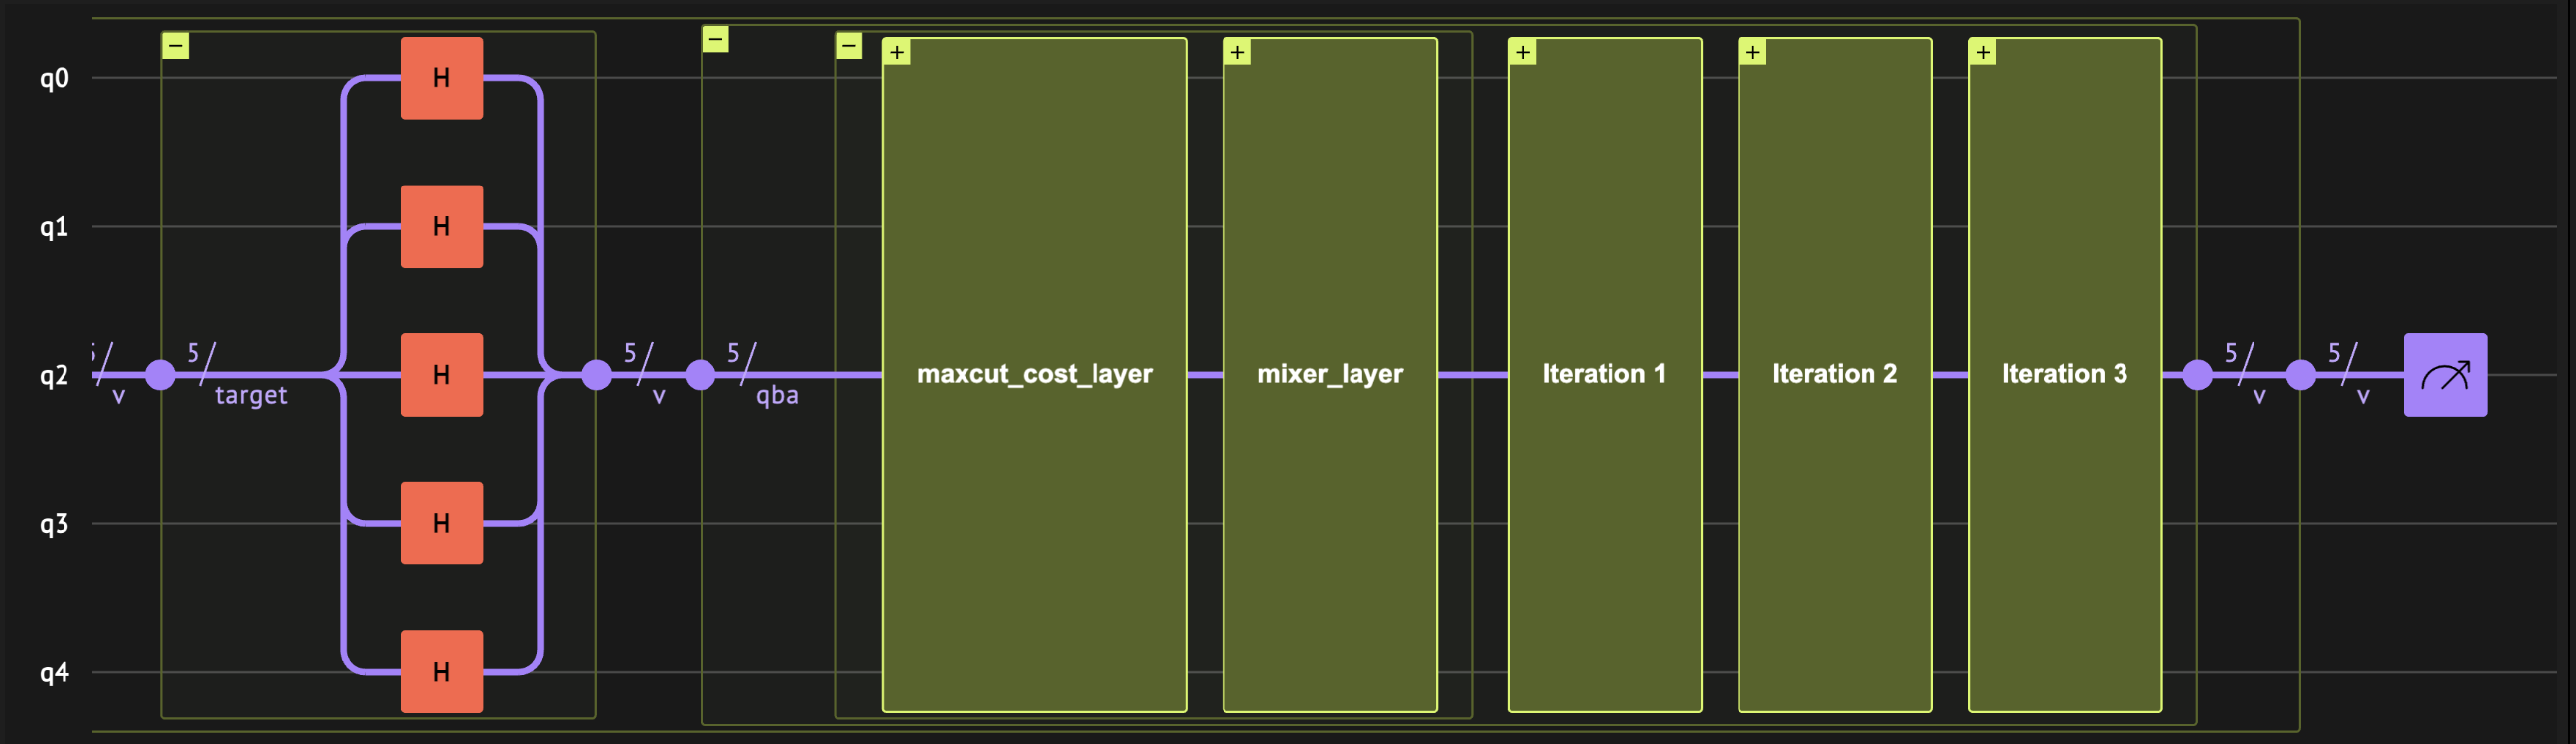

### Set a Specific Problem Instance to Optimize

The implementation we are following is general, but to demonstrate it properly, we chose a specific Max-Cut instance using a **5-node graph**:
- **Vertices:** $V = \{0,1,2,3,4\}$
- **Edges:** $E = \{(0,1), (0,2), (1,2), (1,3), (2,4), (3,4)\}$

#### Optimal Max-Cut Solutions
Several partitions achieve the maximum cut value (cutting 5 out of 6 edges). For example:

**Option 1:**  
- **Set 1:** $\{0,2,3\}$
- **Set 2:** $\{1,4\}$

**Option 2:**  
- **Set 1:** $\{2,3\}$
- **Set 2:** $\{0,1,4\}$

Both options represent optimal solutions for this graph, showcasing the non-uniqueness of the optimal partition in a non-trivial Max-Cut instance.

We begin by uploading packages and declaring the nodes and edges of the graph

In [1]:
import math

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from tqdm import tqdm

from classiq import *

In [2]:
graph_edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]

Visualizing the above-defined graph:

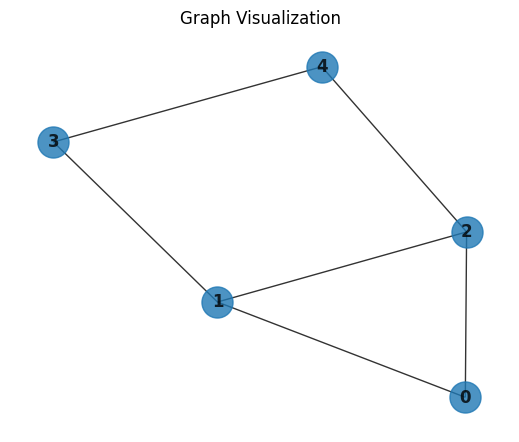

In [3]:
# Create a graph instance
G = nx.Graph()
G.add_edges_from(graph_edges)

# Use a layout for better visualization
pos = nx.spring_layout(G)

# Draw the graph
plt.figure(figsize=(5, 4))  # width, height in inches
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500, font_weight="bold")
plt.title("Graph Visualization")
plt.show()

### Algorithms Building Blocks

#### Cost Layer

The function `maxcut_cost` computes the normalized, negative cost of a partition represented by the quantum state `v`. Instead of using the conventional objective function:
$$
C_{\text{MC}}(x)=\sum_{(i,j) \in E} \frac{1-x_i x_j}{2}
$$
we define it as:

$$
\text{maxcut\_cost}(x) = -\frac{1}{|E|}C_{\text{MC}}(x).
$$

This modification serves two purposes:

- **Normalization:** Dividing by the number of edges $|E|$ scales the cost to $\mathcal{O}(1)$, which helps prevent phase wrap-around in the QAOA circuit.
- **Negation for Minimization:** Reformulating the objective as a minimization problem is consistent with adiabatic approaches where the system transitions to its ground state.

*Note:* This function is reused both in the quantum phase encoding and in the classical optimizer.

In [4]:
def maxcut_cost(v: QArray | list[int]):
    # Returns 1 if the edge is cut (i.e., vertices are in different sets), 0 otherwise.
    def edge_cut(node1, node2):
        return node1 * (1 - node2) + node2 * (1 - node1)

    # Compute the normalized, negative cost of the partition.
    return -sum(edge_cut(v[node1], v[node2]) for (node1, node2) in graph_edges) / len(
        graph_edges
    )

The `maxcut_cost_layer` uses the `phase` operation together with `maxcut_cost` to encode the computed cost into the phase of the quantum state. The parameter $\gamma$ controls the phase angle.

In [5]:
@qfunc
def maxcut_cost_layer(gamma: CReal, v: QArray):
    phase(-maxcut_cost(v), gamma)

The next main building block is the `mixer_layer`. This layer drives transitions between computational basis states by applying $RX$ rotations to all qubits. These transitions allow the quantum state to explore different candidate solutions based on the phases assigned by the cost layer.

#### Mixer Layer

In [6]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray):
    apply_to_all(lambda q: RX(beta, q), qba)

#### QAOA Ansatz

The overall QAOA ansatz alternates between the cost and mixer layers for a specified number of iterations.
The ansatz operates on a uniform superposition state (prepared in the `main` function) by repeatedly applying these two layers.

In [7]:
@qfunc
def qaoa_ansatz(
    cost_layer: QCallable[CReal, QArray],
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray,
):
    repeat(
        betas.len,
        lambda i: [
            cost_layer(gammas[i], qba),
            mixer_layer(betas[i], qba),
        ],
    )

#### Full QAOA algorithm

We now assemble all the algorithmic components to construct the full QAOA algorithm. The quantum program first applies a `hadamard_transform` to prepare the qubits in a uniform superposition. After this initial state preparation, the circuit sequentially applies the cost and mixer layers, each with its own parameters that are updated by the classical optimization loop.

In [8]:
NUM_LAYERS = 4


@qfunc
def main(
    params: CArray[
        CReal, NUM_LAYERS * 2
    ],  # Execution parameters (first half: gammas, second half: betas), used later by the sample method
    v: Output[QArray[QBit, G.number_of_nodes()]],
):
    allocate(v)
    hadamard_transform(v)  # Prepare a uniform superposition
    qaoa_ansatz(
        maxcut_cost_layer,
        params[0:NUM_LAYERS],
        params[NUM_LAYERS : 2 * NUM_LAYERS],
        v,
    )

Having defined the `main` function, we create the model, synthesize it, and display the resulting quantum program. Note that the synthesized program is not yet executable because no parameter set has been specified. An `ExecutionSession` is defined to run the program with different parameter sets (stored in a `CArray[CReal, NUM_LAYERS * 2]`) during optimization, and ultimately to solve the problem using the optimized parameters.

In [9]:
from classiq.execution import *

write_qmod(main, "qaoa_max_cut")
qprog_maxcut = synthesize(main)

show(qprog_maxcut)

Quantum program link: https://platform.classiq.io/circuit/36eYsFoTxhFRNDpSWU5gY66Cc2X


### Classical Optimization

We have constructed a modular, parameterized QAOA circuit for the Max-Cut problem. The circuit accepts a parameter array of size `NUM_LAYERS` $\times 2$, with the first half corresponding to the cost layer parameters (`gammas`) and the second half to the mixer layer parameters (`betas`).

We execute the circuit using an `ExecutionSession`, which is configured to sample a fixed number of shots (`NUM_SHOTS`) per evaluation. The function `ExecutionSession.estimate_cost` computes the cost for a given parameter set using the `maxcut_cost` function embedded in our cost layer.

Our classical optimization uses `scipy.optimize.minimize` with the COBYLA method. By minimizing our (negative) cost function, we are effectively maximizing the number of cut edges.

Below is the code that implements the classical optimization loop.

We define the objective function `objective_func` to evaluate the current parameters. This function takes a parameter vector, converts it to a list, and then calls `es.estimate_cost` with our cost function. The optimizer minimizes this function. Additionally, we initialize two lists—`cost_trace` and `params_history`—to record the cost and parameter values at each iteration for later analysis or debugging.

*Note:* `cost_func` is defined later as a lambda function that computes the cost using `maxcut_cost(state["v"])`.

In [10]:
cost_trace = []
params_history = []

es = ExecutionSession(qprog_maxcut)


def objective_func(params):
    cost_estimation = es.estimate_cost(cost_func, {"params": params.tolist()})
    cost_trace.append(cost_estimation)
    params_history.append(params.copy())
    return cost_estimation

Next, we create an execution session, initialize the parameters, run the COBYLA optimizer to find the best parameters, and finally samples the circuit with the optimized parameters.

In [11]:
NUM_SHOTS = 1000
MAX_ITERATIONS = 60

initial_params = np.concatenate(
    (np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS))
)

# Define the cost function used in the quantum circuit
cost_func = lambda state: maxcut_cost(state["v"])

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)

    optimization_results = scipy.optimize.minimize(
        fun=objective_func,
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    )

optimized_parameters = optimization_results.x.tolist()

# Sample the circuit using the optimized parameters
res = es.sample({"params": optimized_parameters})
es.close()

print(f"Optimized parameters: {optimized_parameters}")

Optimization Progress:  50%|███████████████████████████████████████████████▌                                               | 30/60 [01:35<01:35,  3.19s/it]


Optimized parameters: [1.612218894541748, -0.8492977737168794, 1.8895203273174175, 3.01112201462151, 0.8182679368903977, 1.6432748174760219, -0.4042727477741934, -0.3225529463443293]


Plotting the convergence graph: 

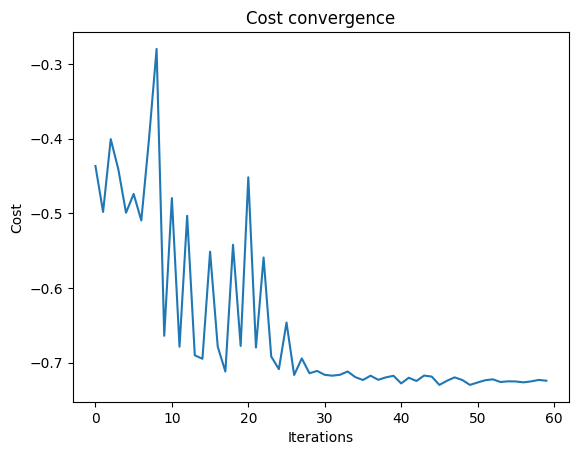

In [12]:
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")
plt.show()

#### Results and Discussion

After optimization, we print the optimized parameters and display the measurement outcomes. Each outcome is a bitstring representing a candidate partition, with its probability (the fraction of shots) and its cost (computed by `maxcut_cost`). For example, a cost of $-0.833$ indicates that $5$ out of $6$ edges are cut, which is optimal for this instance ($5/6 \approx 0.833$).

Below is the code that prints the best $10$ resulting solutions according to the probability:

In [13]:
print(f"Optimized parameters: {optimized_parameters}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: maxcut_cost(pc.state["v"]))
for sampled in sorted_counts[:10]:
    solution = sampled.state["v"]
    probability = sampled.shots / NUM_SHOTS
    cost_value = maxcut_cost(sampled.state["v"])
    print(f"solution={solution} probability={probability:.3f} cost={cost_value:.3f}")

Optimized parameters: [1.612218894541748, -0.8492977737168794, 1.8895203273174175, 3.01112201462151, 0.8182679368903977, 1.6432748174760219, -0.4042727477741934, -0.3225529463443293]
solution=[1, 0, 1, 1, 0] probability=0.306 cost=-0.833
solution=[0, 0, 1, 1, 0] probability=0.303 cost=-0.833
solution=[1, 1, 0, 0, 1] probability=0.298 cost=-0.833
solution=[0, 1, 0, 0, 1] probability=0.285 cost=-0.833
solution=[0, 1, 1, 0, 0] probability=0.120 cost=-0.667
solution=[1, 0, 0, 1, 1] probability=0.109 cost=-0.667
solution=[1, 0, 0, 1, 0] probability=0.099 cost=-0.667
solution=[1, 0, 0, 0, 1] probability=0.085 cost=-0.667
solution=[0, 1, 1, 0, 1] probability=0.077 cost=-0.667
solution=[0, 1, 1, 1, 0] probability=0.074 cost=-0.667


Plotting the solutions with the best cost values:

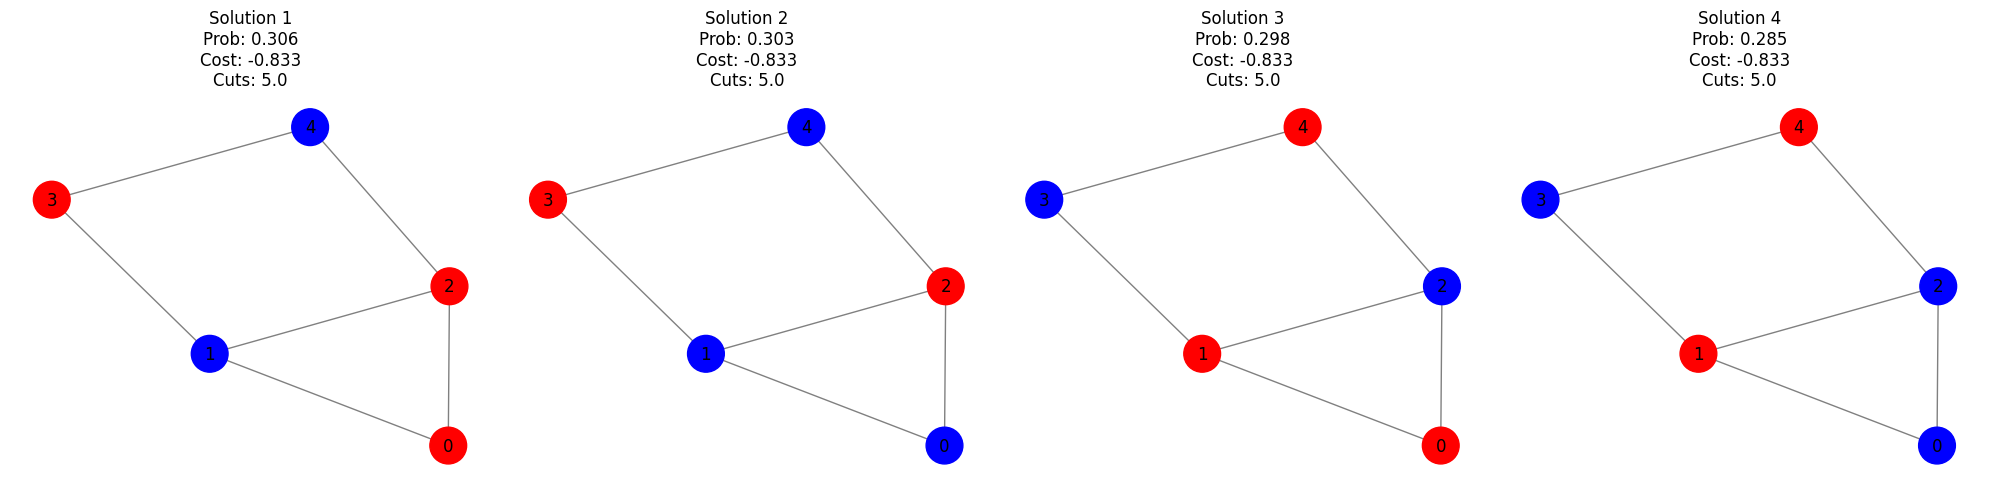

In [14]:
# Determine the best (minimum) cost among all sampled outcomes
best_cost = min(maxcut_cost(pc.state["v"]) for pc in res.parsed_counts)
tolerance = 1e-3

# Filter outcomes with cost within tolerance of best_cost
best_outcomes = [
    pc
    for pc in res.parsed_counts
    if abs(maxcut_cost(pc.state["v"]) - best_cost) < tolerance
]

# Sort outcomes by descending probability
best_outcomes = sorted(best_outcomes, key=lambda pc: pc.shots / NUM_SHOTS, reverse=True)

# Plot the optimal solutions
num_plots = len(best_outcomes)
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
if num_plots == 1:
    axes = [axes]

for i, pc in enumerate(best_outcomes):
    solution = pc.state["v"]
    probability = pc.shots / NUM_SHOTS
    cost_value = maxcut_cost(pc.state["v"])
    num_cuts = abs(cost_value * G.size())  # number of cut edges

    node_colors = ["red" if bit == 1 else "blue" for bit in solution]
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        edge_color="gray",
        ax=axes[i],
        node_size=700,
    )
    axes[i].set_title(
        f"Solution {i+1}\nProb: {probability:.3f}\nCost: {cost_value:.3f}\nCuts: {num_cuts}"
    )

plt.tight_layout()
plt.show()

## Knapsack Problem
The following demonstration will show how to use Classiq for optimizing combinatorial optimization problems with constraints, using the QAOA algorithm [[1](#QAOA)]. The primary objective of the following demonstration is to illustrate how digital and analog quantum operations can be combined to address such problems. The specific problem to optimize will be the knapsack problem [[3](#knapsack)].

Given a set of items, determine how many items to put in the knapsack to maximize their summed value.

- **Input:**
  - Items: A set of items $\{i\}$, and the number of duplicates of the $i$th item, $x_i$, in the knapsack, where each $x_i \in [0, d_i]$ .
  - Weights: A set of item weights, $\{w_i\}$.
  - Values: A set of item values $\{v_i\}$.
  - Weight constraint $C$.
 

- **Output:** Item assignment $\mathbf{x}=\{x_1,\dots,x_N\}$ that maximizes the total value $$\text{value}=\max_{\mathbf{x}} \Sigma_i x_i v_i~~,$$
  subject to a weight constraint $$\Sigma_i w_i x_i\leq C$$

Like the Max-Cut problem, the knapsack is known to be an NP-complete problem.

### Set a specific problem instance to optimize:

Here, we choose a small toy instance:
* Two item types:
  * $x_a \in [0, 7]$ with $w_a=2$, $v_a=3$
  * $x_b \in [0, 3]$ with $w_b=3$, $v_b=5$
* $C = 12$
* The optimal solution is $x_a=3$, $x_b=2$

In this problem, there are additional constraints on the search space. One way to address it is to add a penalty term for the constraints. Here, we take a different approach and take advantage of the quantum nature of the algorithm. 
1. Objective Phase (analog): a phase rotation in the $z$-direction according to the objective value, as done in the vanilla QAOA $$|x\rangle \xrightarrow{U_{C}(\theta)} e^{i\theta C_{\text{KS}}(x)}|x\rangle$$   
2. Constraints Predicate (digital): the constraints are verified digitally, with quantum arithmetics $$|x\rangle|0\rangle \xrightarrow{U_{\text{con}}(\theta)} |x\rangle|\text{con}(x)\rangle$$
   The transformation is done with the numeric assignment transformation, such as `assign` (`|=`).

The transformations are combined in the following manner: For each QAOA cost layer, the objective phase transformation is applied conditioned on the constraints predicate value, such that effectively each infeasible solution will be given a vanishing phase.

This way we can bypass the need to choose a penalty constant, on the expense of additional arithmetic gates for each layer. Note that the method presented here is relevant for positive maximization problems.

### Algorithm Implementation using Classiq

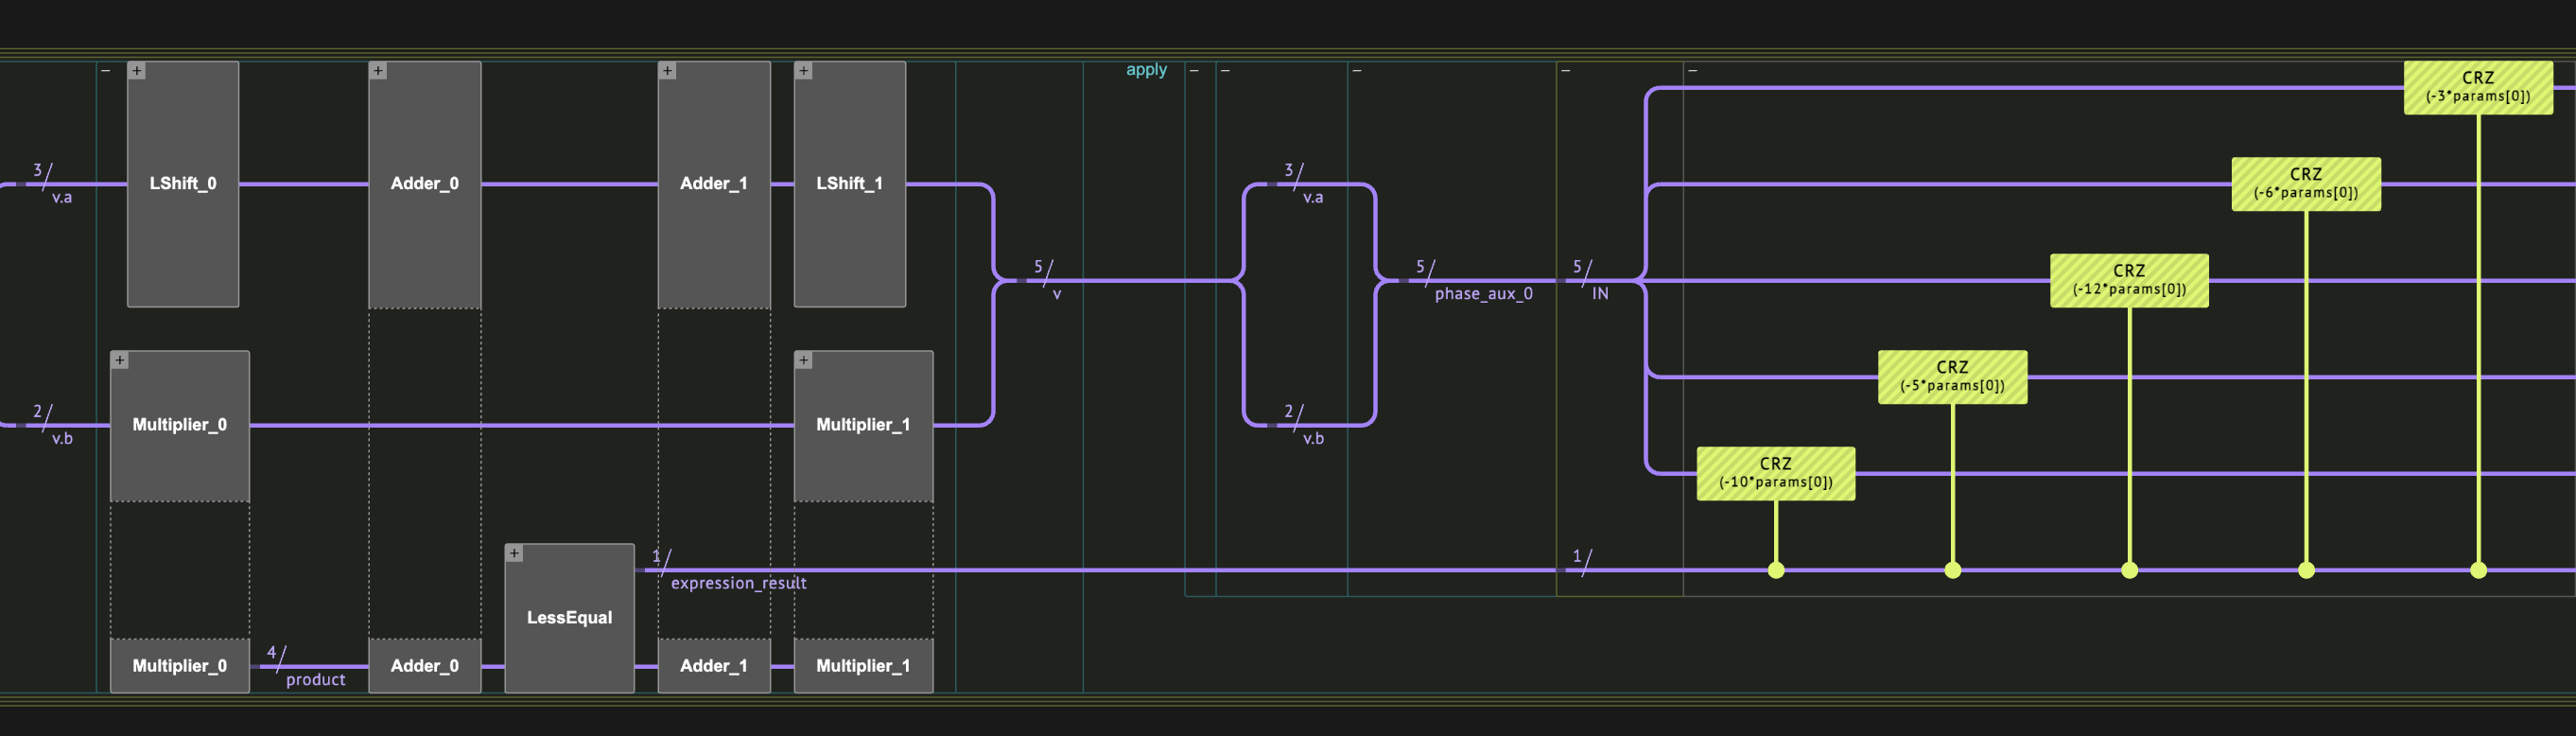

#### Define the knapsack problem

A `QStruct` is used to represent the state of optimization variables. The `value` and `constraint` functions will be used both quantumly, and classicaly in the post-processing.

Notice that the optimization variable are defined as unsigned integers, with the `QNum` type.

In [15]:
class KnapsackVars(QStruct):
    a: QNum[3]
    b: QNum[2]


def value(v: KnapsackVars):
    return v.a * 3 + v.b * 5


def constraint(v: KnapsackVars):
    return v.a * 2 + v.b * 3 <= 12


# assign a negative value to the objective to get maximization
def cost(v: KnapsackVars):
    return -value(v) if constraint(v) else 0

### Apply cost phase controlled on the contraint predicate result

We wrap the `phase` statement with the constraint predicate, so the allocated auxilliary will be released afterwards.
The effective phase will be:
$$
|x\rangle \xrightarrow{\tilde{U}_{C}(\theta)} 
\begin{cases}
e^{i\theta C_{\text{KS}}(x)} |x\rangle & \text{if } \text{constraint}(x) = 1, \\
|x\rangle & \text{if } \text{constraint}(x) = 0~~,
\end{cases}
$$
where $\tilde{U}_{C}$ implements the combined operation of $U_C$ and $U_{\text{con}}$.

In [16]:
@qfunc
def apply_cost(gamma: CReal, v: KnapsackVars) -> None:
    # Rotate states per their objective value, if they satisfy the constraint
    control(
        constraint(v),  # use the digital constraint function
        lambda: phase(-value(v), gamma),
    )

#### Full QAOA algorithm

As in the vanilla QAOA, the cost and mixer layers are applied sequentially with varying parameters, which will be set by the classical optimization loop.

In [17]:
NUM_LAYERS = 3


@qfunc
def main(params: CArray[CReal, NUM_LAYERS * 2], v: Output[KnapsackVars]):
    allocate(v)
    hadamard_transform(v)

    gammas = params[0:NUM_LAYERS]
    betas = params[NUM_LAYERS : 2 * NUM_LAYERS]
    repeat(
        NUM_LAYERS,
        lambda i: [
            apply_cost(gammas[i], v),
            apply_to_all(lambda q: RX(betas[i], q), v),  # mixer layer
        ],
    )


write_qmod(main, "qaoa_knapsack")
qprog_knapsack = synthesize(main, preferences=Preferences(optimization_level=1))
show(qprog_knapsack)

Quantum program link: https://platform.classiq.io/circuit/36eZ5QaFt72p0HWvFd92mAWylDJ


### Classical Optimization

Similarly to the Max-Cut solution we define a `cost_func` for evaluating the cost of a given sample. Notice that the same `value` function that was use in the quantum `phase` application is used here in the classical post-processing.

For the classical optimizer we use `scipy.optimize.minimize` with the `COBYLA` optimization method, that will be called with the `evaluate_params` function.

In [ ]:
NUM_SHOTS = 1000
MAX_ITERATIONS = 60

# start with a linear scheduling guess
initial_params = (
    np.concatenate((np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS)))
    * math.pi
)

cost_trace = []


def evaluate_params(es, params):
    cost_estimation = es.estimate_cost(
        cost_func=lambda state: cost(state["v"]), parameters={"params": params.tolist()}
    )
    cost_trace.append(cost_estimation)
    return cost_estimation


es = ExecutionSession(
    qprog_knapsack, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)  # increment progress bar

    final_params = scipy.optimize.minimize(
        fun=lambda params: evaluate_params(es, params),
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    ).x.tolist()

print(f"Optimized parameters: {final_params}")
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

Optimization Progress:  37%|██████████████████████████████████▊                                                            | 22/60 [01:36<02:25,  3.83s/it]

After the optimization, we sample the the circuit with the optimized parameters:

In [ ]:
res = es.sample({"params": final_params})
es.close()

Print the resulting solutions according to the probability:

In [ ]:
sorted_counts = sorted(res.parsed_counts, key=lambda sampled: cost(sampled.state["v"]))
for sampled in sorted_counts[:10]:
    v = sampled.state["v"]
    print(
        f"solution={v} probability={sampled.shots/NUM_SHOTS} value={value(v)} constraint={constraint(v)}"
    )

We obtain the optimal solution, $(x_a, x_b) = (3,2)$, achieving a value of $19$. 

## Technical Notes

The QAOA algorithm can be related to adiabatic evolution of the system in the limit $p\infty$, thus, producing the optimal under the assumption that the adiabatic theorem's conditions are satisfied.

The **Adiabatic Theorem**:

For a time-dependent Hamiltonian $H(t)$ with instantaneous eigenstates and values, satisfying the eigen equation 
$$H(t)|\psi_n(t)\rangle = E_n(t) |\psi_n(t)\rangle ~~.$$
Assume that for all $t \in [0,T]$
- The eigenvalues $E_m(t)$ of interest is non-degenerate, and 
- It is separated from the rest of the spectrum by a finite gap
  $$ \Delta(t) = \min_{n\neq m}|E_n(t)-E_m(t)|\geq \Delta_{\text{min}}>0~~.$$
If the system starts in that eigenstate at $t=0$, $|\psi (0)\rangle = |\psi_m(0)\rangle~~,$ and the Hamiltonian changes sufficiently slowly (see exact condition in [[4](#Regev)]), then the state at time $t$ remains the corresponding instantaneous eigenstate accompanied with dynamical, and geometric (Berry) phases:
$$|\psi(t)\rangle \approx e^{i\theta_m(t)}e^{i\gamma_m(t)}|\psi_m(t)\rangle ~~,$$
where the dynamical phase is given by $\theta_m(t) = - \int_0^t E_m(\tau)d\tau$, and the geometric obtains the form $ i \int_0^t \langle\psi_m(\tau)| \dot{\psi}_m(\tau) \rangle d\tau$.
In the limit $T\rightarrow \infty$ the theorem is exact and the approximation turns to an equality.
In other words, a sufficiently slow change of the Hamiltonian parameters, with respect to the energy gaps, suppresses transitions between the Hamiltonian eigenvalues.

To show the equivalence between the QAOA algorithm and the adiabatic solution, we consider the parameterized Hamiltonian:
$$ H(s) = (1-s)H_M + s H_C~~,$$ where $s(t)\in [0,1]$ is initialized at zero and gradually increased by some protocol to a final value of one.
Generally, the time-evolution operator is given by $$U(t,0) = {\cal T}e^{-i\int_0^T H(\tau)d\tau}~~,$$ where $\cal T$ denotes the time-ordering operator.

Dividing the dynamics into $N$ consiquent steps, each governed by a constant Hamiltonian, $U(t,0)$ can be approximated by the Trotter expansion [[5](#Trotter)]: $$U(t,0) = \Pi_{k=1}^{N}e^{-i H(s_k)\Delta t}+ O\left((\Delta t)^2 \right)= \Pi_{k=1}^{N} e^{-i H_C s_k\Delta t}e^{-i H_M(1-s_k)\Delta t}  ~~,   $$ where $\Delta t =t/N$. In the limit $N\rightarrow \infty$, the identity becomes exact. 
By choosing $\gamma_k = -\Delta t s_k$ and $\beta_k = -\Delta t (1-s(t_k))$, we obtain the QAOA propagator $$U(t,0) = \Pi_{k=0}^{N} e^{i\gamma_k H_C}e^{i\beta_k H_M}~~.$$ Therefore, by choosing appropriate $\{\gamma_k\}$, and $\{\beta_k\}$, and for sufficiently slow variation of the Hamiltonian, the two time-evolution operators (adiabatic and QAOA) coincide. 

Finally, we recognize that initial state $|\psi(0)\rangle =  H^{\otimes n} |0\rangle^{\otimes n} = |+\rangle^{\otimes n}$ is the ground state of the initial adiabatic Hamiltonian $H(s=0) = H_M$. As a result, under adiabatic dynamics, the system state will evolve to the ground state of the cost Hamiltonian $H(s=1) = H_C$. By construction, this state corresponds to an optimal combinatorial solution. 

Overall, the relationship between the QAOA algorithm and adiabatic evolution demonstrates that, for sufficiently large $p$ (the number of iterations), under the restrictions of the adiabatic theorem, the QAOA algorithm is guaranteed to provide an optimal solution to the classical combinatorial problem. 



## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='knapsack'>[2]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)

<a id='knapsack'>[3]</a>: [Knapsack problem (Wikipedia)](https://en.wikipedia.org/wiki/Knapsack_problem)

<a id='Regev'>[4]</a>: [Ambainis, A., & Regev, O. (2004). An elementary proof of the quantum adiabatic theorem. arXiv preprint quant-ph/0411152.](https://arxiv.org/pdf/quant-ph/0411152)

<a id='Trotter'>[5]</a>: [Zhuk, S., Robertson, N. F., & Bravyi, S. (2024). Trotter error bounds and dynamic multi-product formulas for Hamiltonian simulation. Physical Review Research, 6(3), 033309.](https://arxiv.org/abs/2306.12569)


